<a href="https://colab.research.google.com/github/seven320/air_pollutants/blob/main/FP083_082.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env

In [1]:
!nvidia-smi

Mon May 30 16:54:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os, sys
COLAB = "google.colab" in sys.modules

if COLAB:
    from google.colab import drive
    from google.colab import output
    drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if COLAB:
    !pip install transformers > /dev/null
    !pip install einops > /dev/null
    !pip install optuna > /dev/null
    !pip install pyephem > /dev/null
    # !pip install timm > /dev/null
    # !pip install kaggle > /dev/null
    # !pip install kaggle_datasets > /dev/null
    # !pip install git+https://github.com/albumentations-team/albumentations
    # !pip install tensorflow-determinism
    !pip install -q iterative-stratification
    !pip install python-Levenshtein > /dev/null
    !pip install geopy > /dev/null
    !pip install catboost

    # for gpu
    !git clone --recursive https://github.com/Microsoft/LightGBM
    %cd /content/LightGBM/
    !mkdir build
    !cmake -DUSE_GPU=1 
    !make -j$(nproc)
    !sudo apt-get -y install python-pip

    !sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
    #pandasのエラーが出る場合は上記のコードからpandasを削除

    !sudo -H pip install setuptools numpy scipy scikit-learn -U
    %cd /content/LightGBM/python-package
    !sudo python setup.py install --precompile

    output.clear()

In [4]:
import gc
import json
import math
import os
import random
import re
import time
import copy
import warnings
from requests import get
from contextlib import contextmanager
from typing import List, Optional, TypeVar, Type, Dict
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GroupKFold, train_test_split, KFold
from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from einops.layers.torch import Rearrange, Reduce
# import timm
import Levenshtein
import ephem
from geopy.distance import geodesic
import pickle

from tqdm.notebook import tqdm
from transformers import AdamW, get_cosine_schedule_with_warmup
from typing import Optional, Tuple
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import catboost as cb
import lightgbm as lgb
import optuna

In [5]:
warnings.simplefilter('ignore')

In [6]:
if COLAB:    
    NOTEBOOK_NAME = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    print(NOTEBOOK_NAME)

FP083-082


In [7]:
COMPE_NAME = "air_pollutants"
BASE_DIR = f"/content/drive/MyDrive/signate/{COMPE_NAME}"

# KAGGLE ONLY HAS 1, BUT OFFLINE, YOU CAN USE MORE
os.environ["CUDA_VISIBLE_DEVICES"]="0" #0,1,2,3 for four gpu

In [8]:
if COLAB:
    INPUT_DIR = Path(os.path.join(BASE_DIR ,f"input"))
    INPUT_DIR.mkdir(exist_ok=True, parents=True)

    SAVE_DIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
    SAVE_DIR.mkdir(exist_ok=True, parents=True)

    OOF_DIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
    OOF_DIR.mkdir(exist_ok=True, parents = True)

    SUB_DIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
    SUB_DIR.mkdir(exist_ok=True, parents = True)

In [9]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))
sample_df = pd.read_csv(os.path.join(INPUT_DIR, "submit_sample.csv"), names=["id", "predict"])

print(train_df.shape, test_df.shape, sample_df.shape)

(195941, 54) (53509, 53) (53509, 2)


In [10]:
train_df

,id,year,month,day,Country,City,lat,lon,co_cnt,co_min,...,ws_min,ws_mid,ws_max,ws_var,dew_cnt,dew_min,dew_mid,dew_max,dew_var,pm25_mid
0,1,2019,1,1,Australia,Brisbane,-27.46794,153.02809,38,0.749,...,0.241,1.088,3.101,1.983,17,7.671,10.358,15.112,13.424,19.901
1,2,2019,1,1,Australia,Darwin,-12.46113,130.84185,47,2.594,...,0.828,3.473,7.396,10.411,62,21.324,23.813,24.221,2.021,13.741
2,3,2019,1,1,Australia,Melbourne,-37.81400,144.96332,17,1.190,...,0.000,2.107,8.089,15.719,22,10.309,13.133,15.422,6.355,25.918
3,4,2019,1,1,Australia,Newcastle,-32.92953,151.78010,63,4.586,...,0.284,0.503,3.592,2.485,116,7.146,10.685,13.344,9.417,174.370
4,5,2019,1,1,Australia,Perth,-31.95224,115.86140,47,4.689,...,0.500,0.755,3.396,1.937,93,1.091,3.277,12.272,4.109,167.063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195936,195937,2021,12,31,United States,Jacksonville,30.33218,-81.65565,12,0.694,...,2.195,2.710,6.125,3.757,12,16.774,22.679,26.058,13.252,16.150
195937,195938,2021,12,31,United States,Las Vegas,36.17497,-115.13722,14,0.528,...,1.002,2.974,6.861,8.354,12,10.432,14.741,15.827,7.078,16.895
195938,195939,2021,12,31,United States,Milwaukee,43.03890,-87.90647,171,1.975,...,0.994,1.087,2.578,0.612,26,2.049,3.531,6.686,5.286,86.299
195939,195940,2021,12,31,Vietnam,Hanoi,21.02450,105.84117,31,2.613,...,1.005,3.058,6.005,6.085,51,1.922,7.443,7.716,4.642,36.523


## pseude label

In [11]:
# oof_df = pd.read_csv(os.path.join(BASE_DIR, "oof", "FP046-043", "oof.csv"))
# submit_df = pd.read_csv(os.path.join(BASE_DIR, "submission", "FP046-043", "submission.csv"), names = ["id", "pm25_mid"])

In [12]:
# oof_df_ = oof_df.rename(columns = {"oof":"pseude_pm25_mid"})
# submit_df_ = submit_df.rename(columns = {"pm25_mid":"pseude_pm25_mid"})

## add city population

In [13]:
# population_df = pd.read_csv(os.path.join(INPUT_DIR, "city_population.csv"))
# population_df["City"] = population_df["Name"]

In [14]:
# # 同じ都市名かつ国名のものを削除する
# population_df["CC"] = population_df["Country"] + population_df["City"]
# population_df["CC"].value_counts()
# for k, v in population_df["CC"].value_counts().items():
#     # print(k, v)
#     if v > 1:
#         print(f"{k} の行を削除")
#         population_df = population_df[population_df["CC"] != k]

In [15]:
# def df_to_country_dict(df: pd.DataFrame) -> Dict:
#     country_city = {}

#     for t_c in set(df["Country"].tolist()):
#         country_city[t_c] = []

#     for country, city in zip(df["Country"], df["City"]):
#         country_city[country].append(city)

#     for k, v in country_city.items():
#         country_city[k] = set(v)

#     return country_city

In [16]:
# train_country_city = df_to_country_dict(pd.concat([train_df, test_df]))
# p_country_city = df_to_country_dict(population_df)

In [17]:
# def cal_leven(str1: str, str2: str) -> float:
#     # レーベンシュタイン距離の取得
#     lev_dist = Levenshtein.distance(str1, str2)
#     # 標準化(長い方の文字列の長さで割る)
#     divider = len(str1) if len(str1) > len(str2) else len(str2)
#     lev_dist = lev_dist / divider
#     # 指標を合わせる(0:完全不一致 → 1:完全一致)
#     return 1 - lev_dist

In [18]:
# city_pairs = {}

# for t_k, t_values in train_country_city.items():
#     for p_k, p_values in p_country_city.items():
#         # countryが一致
#         if t_k != p_k:
#             continue
#         for t_v in t_values:
#             max_score = -1
#             for p_v in p_values:
#                 score = cal_leven(t_v, p_v)
#                 if max_score < score:
#                     pairs = [t_v, p_v]
#                     max_score = score

#             if max_score > 0.8:
#                 city_pairs[pairs[1]] = pairs[0]
# print(f"pair cities:{len(city_pairs)}")

In [19]:
# a = population_df["City"]
# for key, value in city_pairs.items():
#     a = copy.deepcopy(a.replace(key, value))

# population_df["City"] = a

In [20]:
# if not "Prev" in train_df.columns:
#     train_df = train_df.merge(population_df[["rank", "City", "Country", "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")
#     test_df = test_df.merge(population_df[["rank", "City", "Country",  "Population", "Prev", "Growth"]], on = ["City", "Country"], how="left")
# assert len(test_df) == len(sample_df)
# assert train_df.shape[0] == 195941

## add foot print data

In [21]:
# footprint_df = pd.read_csv(os.path.join(INPUT_DIR, "footprint.csv"))

# footprints_cap = []
# footprints_cap_w = []
# for vs in footprint_df["Footprint/cap(tCO2)"].str.split("&plusmn;"):
#     v1, v2 = vs
#     footprints_cap.append(v1)
#     footprints_cap_w.append(v2)

# footprint_df["footprint_cap"] = footprints_cap
# footprint_df["footprint_cap_w"] = footprints_cap_w

# footprint_df["footprint_cap"] = footprint_df["footprint_cap"].astype(float)
# footprint_df["footprint_cap_w"] = footprint_df["footprint_cap_w"].astype(float)

# footprints = []
# footprints_w = []
# for vs in footprint_df["Footprint(MtCO2)"].str.split("&plusmn;"):
#     v1, v2 = vs
#     footprints.append(v1)
#     footprints_w.append(v2)

# footprint_df["footprint"] = footprints
# footprint_df["footprint_w"] = footprints_w

# footprint_df["footprint"] = footprint_df["footprint"].astype(float)
# footprint_df["footprint_w"] = footprint_df["footprint_w"].astype(float)

# footprint_df = footprint_df.drop(columns = ["Footprint(MtCO2)", "Footprint/cap(tCO2)"])
# footprint_df = footprint_df.replace({
#     "SouthKorea": 'South Korea', 
#     "USA": "United States",
#     "SouthAfrica": "South Africa",
#     "UnitedKingdom": "United Kingdom",})
# footprint_df["City"] = footprint_df["UrbanCluster"]
# footprint_df = footprint_df.drop(columns = ["UrbanCluster"])

In [22]:
# f_country_city = footprint_df["Country"].unique()
# all_country = pd.concat([train_df, test_df])["Country"].unique()

In [23]:
# f_country_city = df_to_country_dict(footprint_df)

In [24]:
# city_pairs2 = {}

# for t_k, t_values in train_country_city.items():
#     for f_k, f_values in f_country_city.items():
#         # countryが一致
#         if t_k != f_k:
#             continue
#         for t_v in t_values:
#             max_score = -1
#             for f_v in f_values:
#                 score = cal_leven(t_v, f_v)
#                 if max_score < score:
#                     pairs = [t_v, f_v]
#                     max_score = score

#             if max_score > 0.8:
#                 city_pairs2[pairs[1]] = pairs[0]
# print(f"pair cities:{len(city_pairs2)}")

In [25]:
# ## unknowncity lat/lon → city name
# position_master_df = pd.concat([train_df, test_df])[["lat", "lon", "Country", "City"]].drop_duplicates().reset_index(drop=True)
# for c in footprint_df["City"]:
#     if "Unknowncityatlat" in c:
#         lat, lon = c.replace("Unknowncityatlat/lon", "").split(",")
#         for i in position_master_df.index:
#             lat_master, lon_master, city = position_master_df.loc[i, ["lat", "lon", "City"]]
#             if abs(float(lat) - lat_master) + abs(float(lon) - lon_master) < 2:
#                 city_pairs2[c] = city
#                 break

In [26]:
# a = footprint_df["City"]
# for key, value in city_pairs2.items():
#     a = copy.deepcopy(a.replace(key, value))

# footprint_df["City"] = a

# ## 重複している都市を削除
# footprint_df = footprint_df[~footprint_df.duplicated(subset = ["Country", "City"])]

In [27]:
# if not "1StdDev" in train_df.columns:
#     train_df = train_df.merge(footprint_df[["Population", "1StdDev", "Globalranking", "Domesticranking", "footprint_cap", "footprint_cap_w", "footprint", "footprint_w", "City", "Country"]], on = ["City", "Country"], how="left")
#     test_df = test_df.merge(footprint_df[["Population", "1StdDev", "Globalranking", "Domesticranking", "footprint_cap", "footprint_cap_w", "footprint", "footprint_w", "City", "Country"]], on = ["City", "Country"], how="left")
# assert len(test_df) == len(sample_df)
# assert train_df.shape[0] == 195941

## add target encode

In [28]:
if not "target_count" in train_df.columns:
    target_df = train_df[["Country", "pm25_mid"]].groupby("Country", as_index = 1).describe()

    target_df = target_df.rename(columns = {
        "count": "target_count",
        "mean": "target_mean",
        "std": "target_std",
        "25%": "target_25%",
        "50%": "target_50%",
        "75%": "target_75%",
        "max": "target_max"
    }).reset_index()
    train_df = train_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")
    test_df = test_df.merge(pd.concat([target_df["Country"], target_df["pm25_mid"]], axis = 1), on = "Country", how = "left")

### add days

## 都市を近い順に入力(上位15)

In [29]:
use_city = 5

In [30]:
# 全ての都市を抽出
all_df = pd.concat([train_df, test_df])
lat_lons = all_df[["City", "lat", "lon"]].drop_duplicates()

train_cities = train_df["City"].unique()
test_cities = test_df["City"].unique()
all_cities = all_df["City"].unique()

In [31]:
 # 各都市ごとの距離を格納
 #
#  nearest_cities = {
#       City1 = {
            # City2: 500km
            # City3: 1000km
# }
# } 

nearest_cities = {}
for i in tqdm(range(len(lat_lons))):
    City1, lat1, lon1 = lat_lons.iloc[i]
    pos1 = np.array([lat1, lon1])
    
    nearest_city = {}
    for j in range(len(lat_lons)):
        if i == j:
            continue
        
        City2, lat2, lon2 = lat_lons.iloc[j]
        pos2 = np.array([lat2, lon2])
        dis = geodesic(pos1, pos2)
        nearest_city[City2] = dis

    nearest_cities[City1] = nearest_city

  0%|          | 0/302 [00:00<?, ?it/s]

In [32]:
nearest_sort_cities = []

for city1 in nearest_cities.keys():
    nearest_sort_city = dict(sorted(nearest_cities[city1].items(), key = lambda item: item[1])).keys()
    nearest_sort_cities.append([city1] + list(nearest_sort_city)[:use_city])

In [33]:
target_en_bycities_detail = train_df[["City","year", "month","day", "pm25_mid", "so2_mid", "no2_mid", "co_mid", "o3_mid"]].groupby(["City", "year", "month", "day"], as_index = 0).agg("mean").reset_index(drop=True)

In [34]:
# cities = pd.DataFrame(target_en_bycities_detail["City"].unique(), columns = ["City"])
cities = pd.DataFrame(all_df["City"].unique(), columns=["City"])
year_month_day = target_en_bycities_detail.groupby(["year", "month", "day"], as_index=0).agg("mean")[["year", "month", "day"]]

city_year_month_day = pd.merge(cities, year_month_day, how = "cross")

In [35]:
target_en_bycities = train_df[["City","year", "month", "pm25_mid", "so2_mid", "no2_mid", "co_mid", "o3_mid"]].groupby(["City", "month"], as_index = 0).agg("mean").reset_index(drop=True)

In [36]:
target_en = pd.merge(city_year_month_day, target_en_bycities_detail, on = ["City", "year", "month", "day"], how = "left")
target_en_fillna = pd.merge(target_en, target_en_bycities, on = ["City", "year", "month"], how = "left")
target_en_fillna["pm25_mid"] = target_en_fillna["pm25_mid_x"].combine_first(target_en_fillna["pm25_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["pm25_mid_x", "pm25_mid_y"])
target_en_fillna["so2_mid"] = target_en_fillna["so2_mid_x"].combine_first(target_en_fillna["so2_mid_y"])
target_en_fillna["no2_mid"] = target_en_fillna["no2_mid_x"].combine_first(target_en_fillna["no2_mid_y"])
target_en_fillna["co_mid"] = target_en_fillna["co_mid_x"].combine_first(target_en_fillna["co_mid_y"])
target_en_fillna["o3_mid"] = target_en_fillna["o3_mid_x"].combine_first(target_en_fillna["o3_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["so2_mid_x", "so2_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["no2_mid_x", "no2_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["co_mid_x", "co_mid_y"])
target_en_fillna = target_en_fillna.drop(columns = ["o3_mid_x", "o3_mid_y"])

In [37]:
# Config
NUM_FOLDS = 5

In [38]:
#############
## Utility ##
#############
@contextmanager
def timer(name: str):
    t0 = time.time()
    print(f"[{name}] start")
    yield
    print(f"[{name}] done - elapsed {time.time() - t0:.2f}s")

In [39]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [40]:
train_city = train_df["City"].unique().tolist()
test_city = test_df["City"].unique().tolist()

train_city_cnt = len(train_city)
test_city_cnt = len(test_city)

print(f"train city count: {train_city_cnt}")
print(f"test city count: {test_city_cnt}")

print(f"{len(set(train_city) & set(test_city))}")

train city count: 239
test city count: 63
0


In [41]:
kf = GroupKFold(n_splits = NUM_FOLDS)

if not "kfold" in train_df.columns:
    folds = copy.deepcopy(train_df[["id"]])
    folds["kfold"] = -1

    for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df, train_df["pm25_mid"], train_df["City"])):
        print(f"train_idx: {len(train_idx)}, valid_idx: {len(valid_idx)}")
        folds.loc[valid_idx, "kfold"] = fold

    train_df = train_df.merge(folds[["id", "kfold"]], on="id", how="left")

train_idx: 156755, valid_idx: 39186
train_idx: 156758, valid_idx: 39183
train_idx: 156760, valid_idx: 39181
train_idx: 156730, valid_idx: 39211
train_idx: 156761, valid_idx: 39180


# Train

In [42]:
import logging
from typing import List, Optional, TypeVar

import pandas as pd

class AbstractFeatureTransformer:
    def __init__(self):
        self.name = self.__class__.__name__

    def fit_transform(self, input_df: pd.DataFrame, y=None):
        self.fit(input_df, y)
        return self.transform(input_df)

    def fit(self, input_df: pd.DataFrame, y=None):
        pass

    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        raise NotImplementedError

Transformer = TypeVar("Transformer", bound=AbstractFeatureTransformer)

def extract_features(input_df: pd.DataFrame,
                     transformers: List[Transformer],
                     fit: bool = True,
                     logger: Optional[logging.Logger] = None):
    feature_dfs = []
    for transformer in transformers:
        # timerはブロックの実行時間を計測するユーティリティ
        with timer(f"Extract features with {transformer.name}", logger):
            if fit:
                feature_dfs.append(transformer.fit_transform(input_df))
            else:
                feature_dfs.append(transformer.transform(input_df))
    all_features = pd.concat(feature_dfs, axis=1)
    return all_features

In [43]:
class Numericals(AbstractFeatureTransformer):
    def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
        cols = [pd.api.types.is_numeric_dtype(dtype) for dtype in input_df.dtypes]
        return input_df.loc[:, cols]

class LabelEncoding(AbstractFeatureTransformer):
    def __init__(self, columns: List[str]):
        super().__init__()
        self.le_columns = columns
        self.encoders = {
            column: LabelEncoder()
            for column in self.le_columns
        }
        self.__is_fitted = False

    def fit(self, input_df: pd.DataFrame, y: Optional[np.ndarray] = None):
        """
        ラベルに変換する前に欠損値を埋める
        """
        for column in self.le_columns:
            self.encoders[column].fit(input_df[column].fillna(""))
        self.__is_fitted = True

    def transform(
        self, 
        input_df: pd.DataFrame, 
        y: Optional[np.ndarray] = None
    ) -> pd.DataFrame:
        assert self.__is_fitted, "You need to call `fit` first."
        encoded = {}
        for column in self.le_columns:
            encoded[column] = self.encoders[column].transform(
                input_df[column].fillna(""))
        return pd.DataFrame(encoded)

In [44]:
def preprocess_all(train_df:pd.DataFrame, test_df:pd.DataFrame)->pd.DataFrame:
    cnt = 0
    all_df = pd.concat([train_df, test_df])

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid", 
            "co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]

    for i in range(len(mids)):
        if f"scaled_{mids[i]}" in train_df.columns:
            continue
        scaler = MinMaxScaler()
        scaler.fit(all_df[[mids[i]]])
        train_df[f"scaled_{mids[i]}"] = scaler.transform(train_df[[mids[i]]])
        test_df[f"scaled_{mids[i]}"] = scaler.transform(test_df[[mids[i]]])
        cnt += 1
    print("min max scaler")

    train_df["feel_temp"] = 37 - (37 - train_df["temperature_mid"]) / (0.68 - 0.0014 * train_df["humidity_mid"] + (1 / 1.76 + 1.4 * (train_df["ws_mid"] ** 0.75))) - 0.29 * train_df["temperature_mid"] * (1 - train_df["humidity_mid"] / 100)
    test_df["feel_temp"] = 37 - (37 - test_df["temperature_mid"]) / (0.68 - 0.0014 * test_df["humidity_mid"] + (1 / 1.76 + 1.4 * (test_df["ws_mid"] ** 0.75))) - 0.29 * test_df["temperature_mid"] * (1 - test_df["humidity_mid"] / 100)
    print("feel_temp")

    # 緯度経度をbinningしてクラス分類に変更
    train_df["abs_lat"] = abs(train_df["lat"])
    test_df["abs_lat"] = abs(test_df["lat"])

    for i, segs in enumerate([12, 8, 6, 4]):
        _, bins = pd.cut(all_df["lon"], segs, retbins = True)
        train_df[f"class_{i}_lon"] = pd.cut(train_df["lon"], bins)
        test_df[f"class_{i}_lon"] = pd.cut(test_df["lon"], bins)

        _, bins = pd.cut(all_df["lat"], segs, retbins = True)
        train_df[f"class_{i}_lat"] = pd.cut(train_df["lat"], bins)
        test_df[f"class_{i}_lat"] = pd.cut(test_df["lat"], bins)

        train_df[f"class_{i}_area"] = train_df[f"class_{i}_lat"].astype(str) + "-" + train_df[f"class_{i}_lon"].astype(str) 
        test_df[f"class_{i}_area"] = test_df[f"class_{i}_lat"].astype(str)  + "-" + test_df[f"class_{i}_lon"].astype(str) 
        cnt += 3
    print("bin_lon, bin_lat")

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid", 
            "co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]
    
    for m in mids:
        p01 = all_df[m].quantile(0.01)
        p99 = all_df[m].quantile(0.99)
        train_df[f"clipped_{m}"] = train_df[m].clip(p01, p99)
        test_df[f"clipped_{m}"] = test_df[m].clip(p01, p99)
    print("add clipped")

    for m in mids:
        if f"scaled_clipped_{mids}" in train_df.columns:
            continue
        scaler = MinMaxScaler()
        scaler.fit(all_df[[m]])
        train_df[f"scaled_clipped_{m}"] = scaler.transform(train_df[[m]])
        test_df[f"scaled_clipped_{m}"] = scaler.transform(test_df[[m]])
        cnt += 1
    print("add scaled clipped")

    for m in mids:
        for segs in [3, 5, 10]:
            _, bins = pd.cut(all_df[m], segs, retbins=True)
            train_df[f"class_{segs}_{m}"] = pd.cut(train_df[f"clipped_{m}"], bins)
            test_df[f"class_{segs}_{m}"] = pd.cut(test_df[f"clipped_{m}"], bins)
            cnt += 1
    print("add class_mid")

    for m in mids:
        for segs in [3, 5, 10]:
            for i, _ in enumerate([12, 8, 6, 4]):
                train_df[f"class_{m}_area{i}"] =  train_df[f"class_{segs}_{m}"].astype(str) + "+" +  train_df[f"class_{i}_area"].astype(str)
                test_df[f"class_{m}_area{i}"] =  test_df[f"class_{segs}_{m}"].astype(str) + "+" +  test_df[f"class_{i}_area"].astype(str)

    # scaled_mids = ["scaled_clipped_co_mid", "scaled_clipped_o3_mid", "scaled_clipped_so2_mid", "scaled_clipped_no2_mid"]
    # for i in range(len(scaled_mids)):
    #     for j in range(i):
    #         mid0, mid1 = scaled_mids[i], scaled_mids[j]
    #         train_df[f"{mid0}+{mid1}"] = train_df[mid0] + train_df[mid1]
    #         test_df[f"{mid0}+{mid1}"] = test_df[mid0] + test_df[mid1]
    #         cnt += 1
    #         for k in range(j):
    #             mid2 = scaled_mids[k]
    #             train_df[f"{mid0}+{mid1}+{mid2}"] = train_df[mid0] + train_df[mid1] + train_df[mid2]
    #             test_df[f"{mid0}+{mid1}+{mid2}"] = test_df[mid0] + test_df[mid1] + test_df[mid2]
    #             cnt += 1
    #             for l in range(k):
    #                 mid3 = scaled_mids[l]
    #                 train_df[f"{mid0}+{mid1}+{mid2}+{mid3}"] = train_df[mid0] + train_df[mid1] + train_df[mid2] + train_df[mid3]
    #                 test_df[f"{mid0}+{mid1}+{mid2}+{mid3}"] = test_df[mid0] + test_df[mid1] + test_df[mid2] + test_df[mid3]
    #                 cnt += 1

    # all_df = pd.concat([train_df, test_df])
    
    # for i in range(len(scaled_mids)):
    #     for segs in [3, 5]:
    #         for j in range(i):
    #             mid0, mid1 = scaled_mids[i], scaled_mids[j]
    #             plus = f"{mid0}+{mid1}"
    #             _, bins = pd.cut(all_df[plus], segs, retbins = True)
    #             train_df[f"class_{segs}_{plus}"] = pd.cut(train_df[plus], bins)
    #             test_df[f"class_{segs}_{plus}"] = pd.cut(test_df[plus], bins)
    #             cnt += 1
    #             for k in range(j):
    #                 mid2 = scaled_mids[k]
    #                 plus = f"{mid0}+{mid1}+{mid2}"
    #                 _, bins = pd.cut(all_df[plus], segs, retbins = True)
    #                 train_df[f"class_{segs}_{plus}"] = pd.cut(train_df[plus], bins)
    #                 test_df[f"class_{segs}_{plus}"] = pd.cut(test_df[plus], bins)
    #                 cnt += 1
    #                 for l in range(k):
    #                     mid3 = scaled_mids[l]
    #                     plus = f"{mid0}+{mid1}+{mid2}+{mid3}"
    #                     _, bins = pd.cut(all_df[plus], segs, retbins = True)
    #                     train_df[f"class_{segs}_{plus}"] = pd.cut(train_df[plus], bins)
    #                     test_df[f"class_{segs}_{plus}"] = pd.cut(test_df[plus], bins)
    #                     cnt += 1

    return train_df, test_df

In [45]:
def preprocess(df:pd.DataFrame)->pd.DataFrame:
    df_ = copy.deepcopy(df)

    df_["season"] = df["month"] // 3

    # 年月/年月日を追加
    df_["year_month"] = df_["year"].astype("str") + df_["month"].astype("str")
    df_["year_month_day"] = df_["year"].astype("str") + df_["month"].astype("str") + df_["day"].astype("str")
    df_["month_day"] = df_["month"].astype("str") + df_["day"].astype("str")

    df_["year_season"] = df_["year"].astype("str") + df_["season"].astype("str")

    # 月日国/月日都市を追加
    df_["month_day_country"] = df_["month"].astype("str") + df_["day"].astype("str") + df_["Country"].astype("str") 
    df_["month_day_city"] =  df_["month"].astype("str") + df_["day"].astype("str") + df_["City"].astype("str") 

    # 経度をcosに変換
    cnt = 0

    if not "lon_cos" in df_.columns:
        df_["lon_cos"] = np.cos(np.radians((df_["lon"] + 180)))
        df_["lon_sin"] = np.sin(np.radians((df_["lon"] + 180)))
        df_["month_cos"] = np.cos(np.radians(df_["month"] / 12 * 360))
        df_["month_sin"] = np.sin(np.radians(df_["month"] / 12 * 360))
        print("add lon_cos, lon_sin, month_cos, month_sin")
        cnt += 4
    
    df_["DI"] = 0.81 * df_["temperature_mid"] + 0.01 * df_["humidity_mid"] * (0.99 * df_["temperature_mid"] - 14.3) + 46.3
    bin_edges = [-float("inf"), 54, 59, 64, 69, 74, 79, 84, float("inf")]
    df_["class_DI"] = pd.cut(df_["DI"], bin_edges, labels = False)
    print("不快指数とbin")

    df_["class_temperature_mid"] = df_["temperature_mid"] >= 20
    df_["class_temperature_min"] = df_["temperature_min"] >= 20
    print("bin_temperature")
    cnt += 2

    edge = [-float("inf"), 0, 5, 10, 15, 20, 25, 30, float("inf")]
    df_["class_temperature_mid"] = pd.cut(df_["temperature_mid"], edge, labels = False)
    df_["class_temperature_season"] = df_["class_temperature_mid"].astype(str) + df_["season"].astype(str)
    cnt += 2

    # 南半球を北半球のmonthに変更
    if not "month_world" in df_.columns:
        df_["month_world"] = df_["month"]
        df_.loc[df_["lat"] < 0, "month_world"] = df_["month"] + 6
        df_.loc[df_["month_world"] > 12, "month_world"] = df_["month"] - 6
        print("add month_world")
        cnt += 1
    # mid同士を4則
    columns = df_.columns
    mids = []
    for c in columns:
        if "_mid" in c and c != "pm25_mid":
            mids.append(c)

    # 曜日を追加
    def _cal_sun_time(lat:float, lon:float, year:float, month:float, day: float)->float:
        location = ephem.Observer()
        location.lat = str(lat)
        location.lon = str(lon)
        sun = ephem.Sun()

        location.date = datetime.date(year = int(year), month = int(month), day = int(day))
        sun_time_tmp1 = ephem.localtime(location.next_rising(sun)) - ephem.localtime(location.next_setting(sun))
        sun_time_tmp2 = ephem.localtime(location.next_setting(sun)) - ephem.localtime(location.next_rising(sun))

        sun_time = max(sun_time_tmp1.seconds, sun_time_tmp2.seconds)

        return sun_time
    if not "sun_time" in df_.columns:
        u_cols = ["lat", "lon", "year", "month", "day"]

        df_["sun_time"] = -1
        df_["week"] = -1

        mini_df = df_[u_cols]

        sun_time = np.zeros(len(df_))
        weeks = np.zeros(len(df_))
        for i in tqdm(range(len(mini_df))):
            lat, lon, year, month, day = mini_df.iloc[i]
            sun_time[i] = _cal_sun_time(lat, lon, year, month, day)

            # 曜日
            date = datetime.date(int(year), int(month), int(day))
            weeks[i] = date.weekday()

        df_["sun_time"] = sun_time
        df_["week"] = weeks

        print("add sun_time, weeks")
    cnt += 2

    mids = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid"]
    for i in range(len(mids)):
        for j in range(i):
            mid0, mid1 = mids[i], mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]

            cnt += 1
    print("add mids + cal")
    scaled_mids = ["scaled_co_mid", "scaled_o3_mid", "scaled_so2_mid", "scaled_no2_mid"]
    for i in range(len(scaled_mids)):
        for j in range(i):
            mid0, mid1 = scaled_mids[i], scaled_mids[j]
            df_[f"{mid0}+{mid1}"] = df_[mid0] + df_[mid1]
            cnt += 1
            for k in range(j):
                mid2 = scaled_mids[k]
                df_[f"{mid0}+{mid1}+{mid2}"] = df_[mid0] + df_[mid1] + df_[mid2]
                cnt += 1
                for l in range(k):
                    mid3 = scaled_mids[l]
                    df_[f"{mid0}+{mid1}+{mid2}+{mid3}"] = df_[mid0] + df_[mid1] + df_[mid2] + df_[mid3]
                    cnt += 1
    print("add scaled mids")

    maxs = ["co_max", "o3_max", "so2_max", "no2_max", "temperature_max", "humidity_max", "pressure_max", "ws_max", "dew_max"]
    for i in range(len(maxs)):
        for j in range(i):
            max0, max1 = maxs[i], maxs[j]
            df_[f"{max0}+{max1}"] = df_[max0] + df_[max1]

    scaled_maxs = ["scaled_co_max", "scaled_o3_max", "scaled_so2_max", "scaled_no2_max"]
    for i in range(len(scaled_maxs)):
        for j in range(i):
            max0, max1 = scaled_maxs[i], scaled_maxs[j]
            df_[f"{max0}+{max1}"] = df_[max0] + df_[max1]
            cnt += 1
            for k in range(j):
                max2 = scaled_maxs[k]
                df_[f"{max0}+{max1}+{max2}"] = df_[max0] + df_[max1] + df_[max2]
                cnt += 1
                for l in range(k):
                    max3 = scaled_maxs[l]
                    df_[f"{max0}+{max1}+{max2}+{max3}"] = df_[max0] + df_[max1] + df_[max2] + df_[max3]
                    cnt += 1
    print("add scaled maxs")

    print(f"add {cnt} columns")

    return df_

In [46]:
class AbstractTreeModel:
    def __init__(self, prediction_type="regression"):
        self.model = None
        self.prediction_type = prediction_type

    def train(self,
              params: dict,
              X_train: pd.DataFrame,
              y_train: np.ndarray,
              X_val: pd.DataFrame,
              y_val: np.ndarray,
              train_weights: Optional[np.ndarray] = None,
              val_weights: Optional[np.ndarray] = None,
              train_params: Optional[dict] = None):
        if train_params is None:
            train_params = {}

        model = self._train(
            params,
            X_train, y_train,
            X_val, y_val,
            train_weights, val_weights,
            train_params)
        self.model = model
        return self

    def _train(self,
               params,
               X_train,
               y_train,
               X_val,
               y_val,
               train_weights,
               val_weights,
               train_params):
        raise NotImplementedError

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        raise NotImplementedError

    @property
    def feature_names_(self):
        raise NotImplementedError

    @property
    def feature_importances_(self):
        raise NotImplementedError

    def _check_if_trained(self):
        assert self.model is not None, "You need to train the model first"

class LGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        trn_data = lgb.Dataset(X_train, y_train, weight=train_weights)
        val_data = lgb.Dataset(X_val, y_val, weight=val_weights)
        model = lgb.train(params=params,
                          train_set=trn_data,
                          valid_sets=[trn_data, val_data],
                          **train_params,)
                        #   verbose_eval=False)
        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, num_iteration=self.model.best_iteration)

    @property
    def feature_names_(self):
        self._check_if_trained()
        return self.model.feature_name()

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importance(importance_type="gain")

class XGBModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        model = XGBRegressor(**params,
            )

        model.fit(X_train, y_train, 
                  eval_set = [(X_val, y_val)], 
                  **train_params
                  )

        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X, self.model.get_best_iteraion())

    @property
    def feature_names_(self):
        self._check_if_trained()
        # return self.use_cols

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importances_

class CatBoostModel(AbstractTreeModel):
    def _train(self,
               params,
               X_train, y_train,
               X_val, y_val,
               train_weights, val_weights,
               train_params):
        
        
        trn_data = cb.Pool(X_train, y_train)
        val_data = cb.Pool(X_val, y_val)

        model = CatBoostRegressor(**params)
        model.fit(X_train,
                  y_train,
                  eval_set = val_data,
                  **train_params
        )

        return model

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        self._check_if_trained()
        return self.model.predict(X)

    @property
    def feature_names_(self):
        self._check_if_trained()
        # return self.use_cols

    @property
    def feature_importances_(self):
        self._check_if_trained()
        return self.model.feature_importances_


def get_tree_model(name: str) -> Type[AbstractTreeModel]:
    DEFINED_MODELS = {
        "lgb": LGBModel,
        "xgb": XGBModel,
        "cat": CatBoostModel,
    }
    model = DEFINED_MODELS.get(name)
    if model is None:
        raise ValueError(
            """Invalid model name: {}.
            Pre-defined model names are as follows: {}""".format(
                name,
                ",".join(DEFINED_MODELS.keys())
            ))
    return model

In [47]:
def viz_feature_importances(feature_importances: pd.DataFrame)-> None:
    fi_gby = feature_importances.groupby("feature").agg({
        "importance": ["mean", "std"]
    }).sort_values(("importance", "mean"), ascending=0).index
    plt.figure(figsize=(30, 20))
    
    sns.barplot(x="importance", y="feature", data=feature_importances, order=fi_gby)

    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [48]:
num_cols = [c for c in train_df.columns if train_df[c].dtype != np.object]
if "id" in num_cols:
    num_cols.remove("id")
if "kfold" in num_cols:
    num_cols.remove("kfold")
num_cols.remove("pm25_mid")

target_cols = "pm25_mid"

In [49]:
train_df0, test_df0 = preprocess_all(train_df, test_df)

train_df1 = preprocess(train_df0)
test_df1 = preprocess(test_df0)

min max scaler
feel_temp
bin_lon, bin_lat
add clipped
add scaled clipped
add class_mid
add lon_cos, lon_sin, month_cos, month_sin
不快指数とbin
bin_temperature
add month_world


  0%|          | 0/195941 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add scaled mids
add scaled maxs
add 69 columns
add lon_cos, lon_sin, month_cos, month_sin
不快指数とbin
bin_temperature
add month_world


  0%|          | 0/53509 [00:00<?, ?it/s]

add sun_time, weeks
add mids + cal
add scaled mids
add scaled maxs
add 69 columns


In [50]:
# all_df1 = pd.concat([train_df1, test_df1])

# after_before_cs = ["year", "month", "day", "co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid",
#             "scaled_no2_mid+scaled_so2_mid+scaled_co_mid"]

# today_df = pd.merge(city_year_month_day, 
#             all_df1[after_before_cs + ["City"]],
#             on=["City", "year", "month", "day"], how = "left")

# daybefore_df= today_df.groupby(["City"]).shift()
# dayafter_df = today_df.groupby(["City"]).shift(-1)

# columns_dic = {}
# daybefore_cs = []
# for c in after_before_cs:
#     columns_dic[c] = f"1dbefore_{c}"
#     daybefore_cs.append(f"1dbefore_{c}")

# daybefore_df = daybefore_df.rename(columns = columns_dic)

# columns_dic = {}
# dayafter_cs = []
# for c in after_before_cs:
#     columns_dic[c] = f"1dafter_{c}"
#     dayafter_cs.append(f"1dafter_{c}")

# dayafter_df = dayafter_df.rename(columns = columns_dic)

# beforeafterday_df = pd.concat([today_df[["City", "year", "month", "day"]], daybefore_df[daybefore_cs], dayafter_df[dayafter_cs]], axis =1)

In [51]:
IDW_ps = [1, 1.2, 1.5, 2]
days = [-2, -1, 0, 1, 2]

In [52]:
cat_cols = ["Country", "City", "year_month", "year_season", "season", "year_month_day", "month_day", "month_day_city", "month_day_country", "nearest_city"]

for c in list(set(train_df1.columns)):
    if "class_" in c:
        cat_cols += [c]

day_columns = ["co_mid", "o3_mid", "so2_mid", "no2_mid", "temperature_mid", "humidity_mid", "pressure_mid", "ws_mid", "dew_mid"] + \
["scaled_no2_mid+scaled_so2_mid+scaled_o3_mid+scaled_co_mid", "scaled_co_mid"] + \
["nearest_pm25_mid", ] + \
[f"IDW_p{p}_pm25_mid" for p in IDW_ps] 

IDW_columns = ["pm25_mid", "no2_mid", "so2_mid", "co_mid", "o3_mid"]

num_cols = list(set(train_df1.columns) - set(cat_cols + ["pm25_mid", "kfold", "id", "year"])) + \
 ["nearest_pm25_mid"] + \
[f"dis{i}km_pm25_mid" for i in [100, 300, 500, 1000]] +\
[f"IDW_p{p}_pm25_mid" for p in IDW_ps]

for p in IDW_ps:
    for IDW_c in IDW_columns:
        if IDW_c == "pm25_mid": continue
        num_cols += [f"IDW_p{p}_{IDW_c}"] 
        num_cols += [f"ratio_p{p}_{IDW_c}"]  
        num_cols += [f"correction{IDW_c}_IDW_p{p}_pm25_mid"]

for day in days:
    for day_column in day_columns:
        if day == 0:
            continue
        num_cols += [f"{day}d_{day_column}"]

use_cols = num_cols + cat_cols

In [53]:
print(len(use_cols))

488


#### for tuning

In [54]:
# models = []

# oof_df = train_df_[["id"]]
# oof_df["oof"] = -1

# from lightgbm import early_stopping
# from lightgbm import log_evaluation

# # for i in range(NUM_FOLDS):
# i = 0
# train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
# valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
# print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
# print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

# # fold内での最近傍を探す
# train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
# print(len(train_data["City"].unique()))

# # 同じfoldの中で最近傍な都市があった場合はその年のtarget_encodingを実施
# # nearest_city_fold_df = copy.deepcopy(nearest_city_df)
# fold_cities = train_data["City"].unique()

# fold_nearest_cities = []
# for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
#     if city1 in fold_cities:
#         nearest_city = city1
#     elif city2 in fold_cities:
#         nearest_city = city2
#     elif city3 in fold_cities:
#         nearest_city = city3
#     elif city4 in fold_cities:
#         nearest_city = city4
#     elif city5 in fold_cities:
#         nearest_city = city5
#     fold_nearest_cities.append([base_c, nearest_city])
# fold_nearest_cities_df = pd.DataFrame(fold_nearest_cities, columns = ["City", "nearest_city"])

# # add city distance
# fold_nearest_cities_df["distance_km"] = -1
# for j in range(fold_nearest_cities_df.shape[0]):
#     city, nearest_city = fold_nearest_cities_df.loc[j, ["City", "nearest_city"]]
#     dis = nearest_cities[city][nearest_city]
#     fold_nearest_cities_df.loc[j, "distance_km"] = dis.km

# target_en_fillna_ = target_en_fillna.rename(columns = {"City": "nearest_city", "pm25_mid": "nearest_pm25_mid", 
#                                                         "1dafter_pm25_mid":"nearest_1dafter_pm25_mid", "1dbefore_pm25_mid":"nearest_1dbefore_pm25_mid"})
# fold_nearest_city_target_en = fold_nearest_cities_df.merge(target_en_fillna_, how = "left", on= "nearest_city")

# train_data = train_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
# valid_data = valid_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])

# # 距離に応じた近傍の都市のpm25_mid
# for dis in [50, 100, 300, 500, 1000]:
#     train_data[f"dis{dis}km_pm25_mid"] = np.nan
#     valid_data[f"dis{dis}km_pm25_mid"] = np.nan

#     train_data.loc[train_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = train_data.loc[train_data["distance_km"] <= dis, "nearest_pm25_mid"]
#     valid_data.loc[valid_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = valid_data.loc[valid_data["distance_km"] <= dis, "nearest_pm25_mid"]

# # test
# if i == 0:
#     test_nearest_cities = []
#     for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
#         nearest_city = city1
#         test_nearest_cities.append([base_c, nearest_city])
#     test_nearest_cities_df = pd.DataFrame(test_nearest_cities, columns = ["City", "nearest_city"])
    
#     for j in range(test_nearest_cities_df.shape[0]):
#         city, nearest_city = test_nearest_cities_df.loc[j, ["City", "nearest_city"]]
#         dis = nearest_cities[city][nearest_city]
#         test_nearest_cities_df.loc[j, "distance_km"] = dis.km

#     test_nearest_city_target_en = test_nearest_cities_df.merge(target_en_fillna_, how="left", on = "nearest_city")
#     test_df_ = test_df_.merge(test_nearest_city_target_en, how="left", on=["City", "year", "month", "day"])
#     for dis in [50, 100, 300, 500, 1000]:
#         test_df_[f"dis{dis}km_pm25_mid"] = np.nan
#         test_df_.loc[test_df_["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = test_df_.loc[test_df_["distance_km"] <= dis, "nearest_pm25_mid"]
#     test_df__ = copy.deepcopy(test_df_)

# for c in cat_cols:
#     le = LabelEncoder()
#     le.fit(pd.concat([train_data, valid_data, test_df_])[c])
#     train_data[c] = le.transform(train_data[c])
#     valid_data[c] = le.transform(valid_data[c])
#     if i == 0:
#         test_df__[c] = le.transform(test_df_[c])

In [55]:
# lgb_train = lgb.Dataset(train_data[use_cols], train_data[target_cols])
# lgb_eval = lgb.Dataset(valid_data[use_cols], valid_data[target_cols])

In [56]:
# lgb_train = lgb.Dataset(train_data[use_cols], train_data[target_cols])
# lgb_eval = lgb.Dataset(valid_data[use_cols], valid_data[target_cols])

# def objective(trial):
#     params= {
#             'boosting': trial.suggest_categorical("boosting", ["gbdt", "rf"]),
#             'objective': 'rmse',
#             'metric': 'rmse',
#             'learning_rate': trial.suggest_uniform('learning_rate', 0.001, 0.1),
#             "max_depth": trial.suggest_categorical("max_depth", [8, 16, 32]),
#             "num_leaves": trial.suggest_categorical("num_leaves", [8, 16, 32, 64]),
#             'subsample': 0.7,
#             'subsample_freq': 1,
#             "min_data_in_leaf": 30,
#             "device": "gpu",  
#             "seed":2022,
#     }
#     model = get_tree_model("lgb")()
#     gbm = lgb.train(params, lgb_train, valid_sets=lgb_eval, **train_params)
#     preds = gbm.predict(valid_data[use_cols])

#     accuracy = np.sqrt(mean_squared_error(valid_data[target_cols], preds))
#     return accuracy

In [57]:
# study = optuna.create_study(direction = "minimize")
# study.optimize(objective, n_trials = 50)

#### Train

###### lightGBM

In [58]:
params= {
        'boosting': 'gbdt',
        'objective': 'rmse',
        'metric': 'rmse',
        'learning_rate': 0.00685,
        "max_depth": 8,
        "num_leaves": 64,
        'subsample': 0.7,
        'subsample_freq': 1,
        "min_data_in_leaf":30, 
        "device": "gpu",  
        "seed":2022,
        "feature_fraction": 0.5,
}

train_params = {
    "num_boost_round": 50000,
    "callbacks": [
                  lgb.early_stopping(stopping_rounds= 1000, verbose=True),
                  lgb.log_evaluation(period = 500)
    ]
}

###### XGboost

In [59]:
# params = {
#         "objective":"reg:linear",
#         "n_estimators":20000,
#         'eta': 0.05064176893220393,
#         'max_depth': 8, 
#         'learning_rate': 0.00460851283030278,
#         "subsample":0.7,
#         "eval_metric":"rmse", 
#         "seed":123,
#         "tree_method":"gpu_hist"
# }

# train_params = {
#     "verbose":1000, 
#     "early_stopping_rounds":500
# }

###### catboost パラメータ

In [60]:
# params = {
#     "task_type": "GPU",
#     "iterations": 20000,
#     # "n_estimators": 1000,
#     # "num_trees":8,
#     # "learning_rate":0.01,
#     # "depth":8,
#     "loss_function": "RMSE",
#     "early_stopping_rounds":500,
#     "random_seed":2022,
#     "use_best_model":True,
# }

# # iterations, n_estimators, num_boost_round, num_trees

# train_params = {
#     "verbose": 500,
# }
# # train_params = {
# #     # "verbose":1000, 
# #     # "early_stopping_rounds":500
# # }

In [61]:
len(target_en_fillna.query(f'City == "{city1}"')["pm25_mid"].values)

1095

In [62]:
models = []

train_df_ = copy.deepcopy(train_df1)
test_df_ = copy.deepcopy(test_df1)

oof_df = train_df_[["id"]]
oof_df["oof"] = -1

from lightgbm import early_stopping
from lightgbm import log_evaluation

part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
target_en_dic_bycity = {}
for IDW_c in IDW_columns:
    target_en_dic_bycity[IDW_c] = {}
    for city in tqdm(part_target_en_fillna["City"].unique()):
        target_en_dic_bycity[IDW_c][city] = part_target_en_fillna.query(f"City == '{city}'")[f"{IDW_c}"].values 

for i in range(NUM_FOLDS):
    model = get_tree_model("lgb")()
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    valid_data = train_df_[train_df_["kfold"] == i].reset_index(drop = True)
    print("-" * 5 + f"FOLD {i + 1}/{NUM_FOLDS}" + "-"*5)
    print(f"train_data nums: {len(train_data)}, valid_data nums: {len(valid_data)}")

    # fold内での最近傍を探す
    train_data = train_df_[train_df_["kfold"] != i].reset_index(drop = True)
    print(len(train_data["City"].unique()))

    # 同じfoldの中で最近傍な都市があった場合はその年のtarget_encodingを実施
    # nearest_city_fold_df = copy.deepcopy(nearest_city_df)
    fold_cities = train_data["City"].unique()

    fold_nearest_cities = []
    for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
        if city1 in fold_cities:
            nearest_city = city1
        elif city2 in fold_cities:
            nearest_city = city2
        elif city3 in fold_cities:
            nearest_city = city3
        elif city4 in fold_cities:
            nearest_city = city4
        elif city5 in fold_cities:
            nearest_city = city5
        fold_nearest_cities.append([base_c, nearest_city])
    fold_nearest_cities_df = pd.DataFrame(fold_nearest_cities, columns = ["City", "nearest_city"])

    # add city distance
    fold_nearest_cities_df["distance_km"] = -1
    for j in range(fold_nearest_cities_df.shape[0]):
        city, nearest_city = fold_nearest_cities_df.loc[j, ["City", "nearest_city"]]
        dis = nearest_cities[city][nearest_city]
        fold_nearest_cities_df.loc[j, "distance_km"] = dis.km

    target_en_fillna_ = target_en_fillna.rename(columns = {"City": "nearest_city", "pm25_mid": "nearest_pm25_mid", "co_mid": "co_mid2", 
                                                           "so2_mid": "so2_mid2", "no2_mid": "no2_mid2", "o3_mid": "o3_mid2"})
    fold_nearest_city_target_en = fold_nearest_cities_df.merge(target_en_fillna_, how = "left", on= "nearest_city")
    train_data = train_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(fold_nearest_city_target_en, how = "left", on = ["City", "year", "month", "day"])
    
# IDWによる計算(https://mf-atelier.sakura.ne.jp/mf-atelier2/a40/)
    part_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
    for p in IDW_ps:
        for IDW_c in IDW_columns:
            part_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
            for city in train_cities:
                sum_w = 0
                sum_w_u = 0
                for other_city, dis in nearest_cities[city].items():
                    if not other_city in fold_cities:
                        continue
                # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                    w = 1 / (dis.km ** p)
                    u = target_en_dic_bycity[IDW_c][other_city]
                    u_nan_mask = np.nan_to_num(u)
                    u_nan_flg = np.isnan(u)
                    sum_w_u += w * u_nan_mask
                    sum_w += w * (1 - u_nan_flg)
                part_target_en_fillna.loc[part_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
    part_target_en_fillna = part_target_en_fillna.drop(columns = IDW_columns)
    train_data = train_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(part_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])
    # 距離に応じた近傍の都市のpm25_mid    
    for dis in [100, 300, 500, 1000]:
        train_data[f"dis{dis}km_pm25_mid"] = np.nan
        valid_data[f"dis{dis}km_pm25_mid"] = np.nan
        train_data.loc[train_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = train_data.loc[train_data["distance_km"] <= dis, "nearest_pm25_mid"]
        valid_data.loc[valid_data["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = valid_data.loc[valid_data["distance_km"] <= dis, "nearest_pm25_mid"]

    # 日付をずらす
    train_valid_data = pd.concat([train_data, valid_data])
    days_shift_df = city_year_month_day.merge(train_valid_data[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
    for day in days: 
        for day_column in day_columns:
            if day == 0:
                continue
            days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]

    days_shift_df = days_shift_df.drop(columns = day_columns)

    train_data = train_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])
    valid_data = valid_data.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])

    for p in IDW_ps:
        for IDW_c in IDW_columns:
            if IDW_c == "pm25_mid": continue
            train_data[f"ratio_p{p}_{IDW_c}"] = train_data[f"{IDW_c}"] / (train_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            train_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = train_data[f"ratio_p{p}_{IDW_c}"] * train_data[f"IDW_p{p}_pm25_mid"]
            valid_data[f"ratio_p{p}_{IDW_c}"] = valid_data[f"{IDW_c}"] / (valid_data[f"IDW_p{p}_{IDW_c}"] + 1e-3)
            valid_data[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = valid_data[f"ratio_p{p}_{IDW_c}"] * valid_data[f"IDW_p{p}_pm25_mid"]

    # test
    if i == 0:
        test_nearest_cities = []
        for (base_c, city1, city2, city3, city4, city5) in nearest_sort_cities:
            nearest_city = city1
            test_nearest_cities.append([base_c, nearest_city])
        test_nearest_cities_df = pd.DataFrame(test_nearest_cities, columns = ["City", "nearest_city"])
        
        for j in range(test_nearest_cities_df.shape[0]):
            city, nearest_city = test_nearest_cities_df.loc[j, ["City", "nearest_city"]]
            dis = nearest_cities[city][nearest_city]
            test_nearest_cities_df.loc[j, "distance_km"] = dis.km

        test_nearest_city_target_en = test_nearest_cities_df.merge(target_en_fillna_, how="left", on = "nearest_city")
        test_df_ = test_df_.merge(test_nearest_city_target_en, how="left", on=["City", "year", "month", "day"])

        fortest_target_en_fillna = target_en_fillna[["City", "year", "month", "day"] + IDW_columns]
        for p in IDW_ps:
            for IDW_c in IDW_columns:
                fortest_target_en_fillna[f"IDW_p{p}_{IDW_c}"] = np.nan
                for city in all_cities:
                    sum_w = 0
                    sum_w_u = 0
                    for other_city, dis in nearest_cities[city].items():
                        if not other_city in train_cities:
                            continue
                    # fold_nearest_cities_dfに含まれている都市との距離とpm25の値が欲しい
                        w = 1 / (dis.km ** p)
                        u = target_en_dic_bycity[IDW_c][other_city]
                        u_nan_mask = np.nan_to_num(u)
                        u_nan_flg = np.isnan(u)
                        sum_w_u += w * u_nan_mask
                        sum_w += w * (1 - u_nan_flg)
                    fortest_target_en_fillna.loc[fortest_target_en_fillna["City"] == city, f"IDW_p{p}_{IDW_c}"] = sum_w_u / sum_w
        fortest_target_en_fillna = fortest_target_en_fillna.drop(columns = IDW_columns)
        test_df_ = test_df_.merge(fortest_target_en_fillna, how = "left", on = ["City", "year", "month", "day"])    
        for dis in [100, 300, 500, 1000]:
            test_df_[f"dis{dis}km_pm25_mid"] = np.nan
            test_df_.loc[test_df_["distance_km"] <= dis, f"dis{dis}km_pm25_mid"] = test_df_.loc[test_df_["distance_km"] <= dis, "nearest_pm25_mid"]

        days_shift_df = city_year_month_day.merge(test_df_[day_columns + ["City", "year", "month", "day"]], on = ["City", "year", "month", "day"], how = "left")
        for day in days:
            for day_column in day_columns:
                if day == 0:
                    continue
                days_shift_df[f"{day}d_{day_column}"] = days_shift_df.groupby("City").shift(day)[day_column]
        days_shift_df = days_shift_df.drop(columns = day_columns)
        test_df_ = test_df_.merge(days_shift_df, how = "left",  on = ["City", "year", "month", "day"])

        for p in IDW_ps:
            for IDW_c in IDW_columns:
                if IDW_c == "pm25_mid": continue
                test_df_[f"ratio_p{p}_{IDW_c}"] = test_df_[f"{IDW_c}"] / (test_df_[f"IDW_p{p}_{IDW_c}"] + 1e-3)
                test_df_[f"correction{IDW_c}_IDW_p{p}_pm25_mid"] = test_df_[f"ratio_p{p}_{IDW_c}"] * test_df_[f"IDW_p{p}_pm25_mid"]

        test_df__ = copy.deepcopy(test_df_)

    train_data__ = copy.deepcopy(train_data)
    valid_data__ = copy.deepcopy(valid_data)
    for c in cat_cols:
        le = LabelEncoder()
        ## TODO: concatの部分をcでまとめるとよりはやい
        le.fit(pd.concat([train_data, valid_data, test_df_])[c])
        train_data__[c] = le.transform(train_data[c])
        valid_data__[c] = le.transform(valid_data[c])
        if i == 0:
            test_df__[c] = le.transform(test_df_[c])
            
    train_data__ = train_data__.sample(frac=1, random_state = 0)
    model.train(
        params,
        train_params = train_params,
        X_train = train_data__[use_cols],
        y_train = train_data__[target_cols],
        X_val = valid_data__[use_cols],
        y_val = valid_data__[target_cols],
    )
    # save model
    with open(os.path.join(SAVE_DIR, f"model_{i}.pkl"), "wb") as p:
        pickle.dump(model, p)
    models.append(model)

    if i == 0:
        feature_importance = pd.DataFrame()
        feature_importance["feature"] = use_cols
        feature_importance["importance"] = model.feature_importances_
    else:
        feature_importance["importance"] += model.feature_importances_

    oof = model.predict(
        valid_data__[use_cols]
    )
    oof_df.loc[train_df["kfold"] == i, "oof"] = oof

train_oof = train_df.merge(oof_df[["id", "oof"]], on = "id", how = "left")

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

-----FOLD 1/5-----
train_data nums: 156755, valid_data nums: 39186
192
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 90794
[LightGBM] [Info] Number of data points in the train set: 156755, number of used features: 468
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 452 dense feature groups (67.57 MB) transferred to GPU in 0.050077 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 58.695189
Training until validation scores don't improve for 1000 rounds
[500]	training's rmse: 20.1504	valid_1's rmse: 24.8907
[1000]	training's rmse: 18.8138	valid_1's rmse: 24.0179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1500]	training's rmse: 18.0698	valid_1's rmse: 23.7724
[LightGBM] [Warning] No further splits with positive 

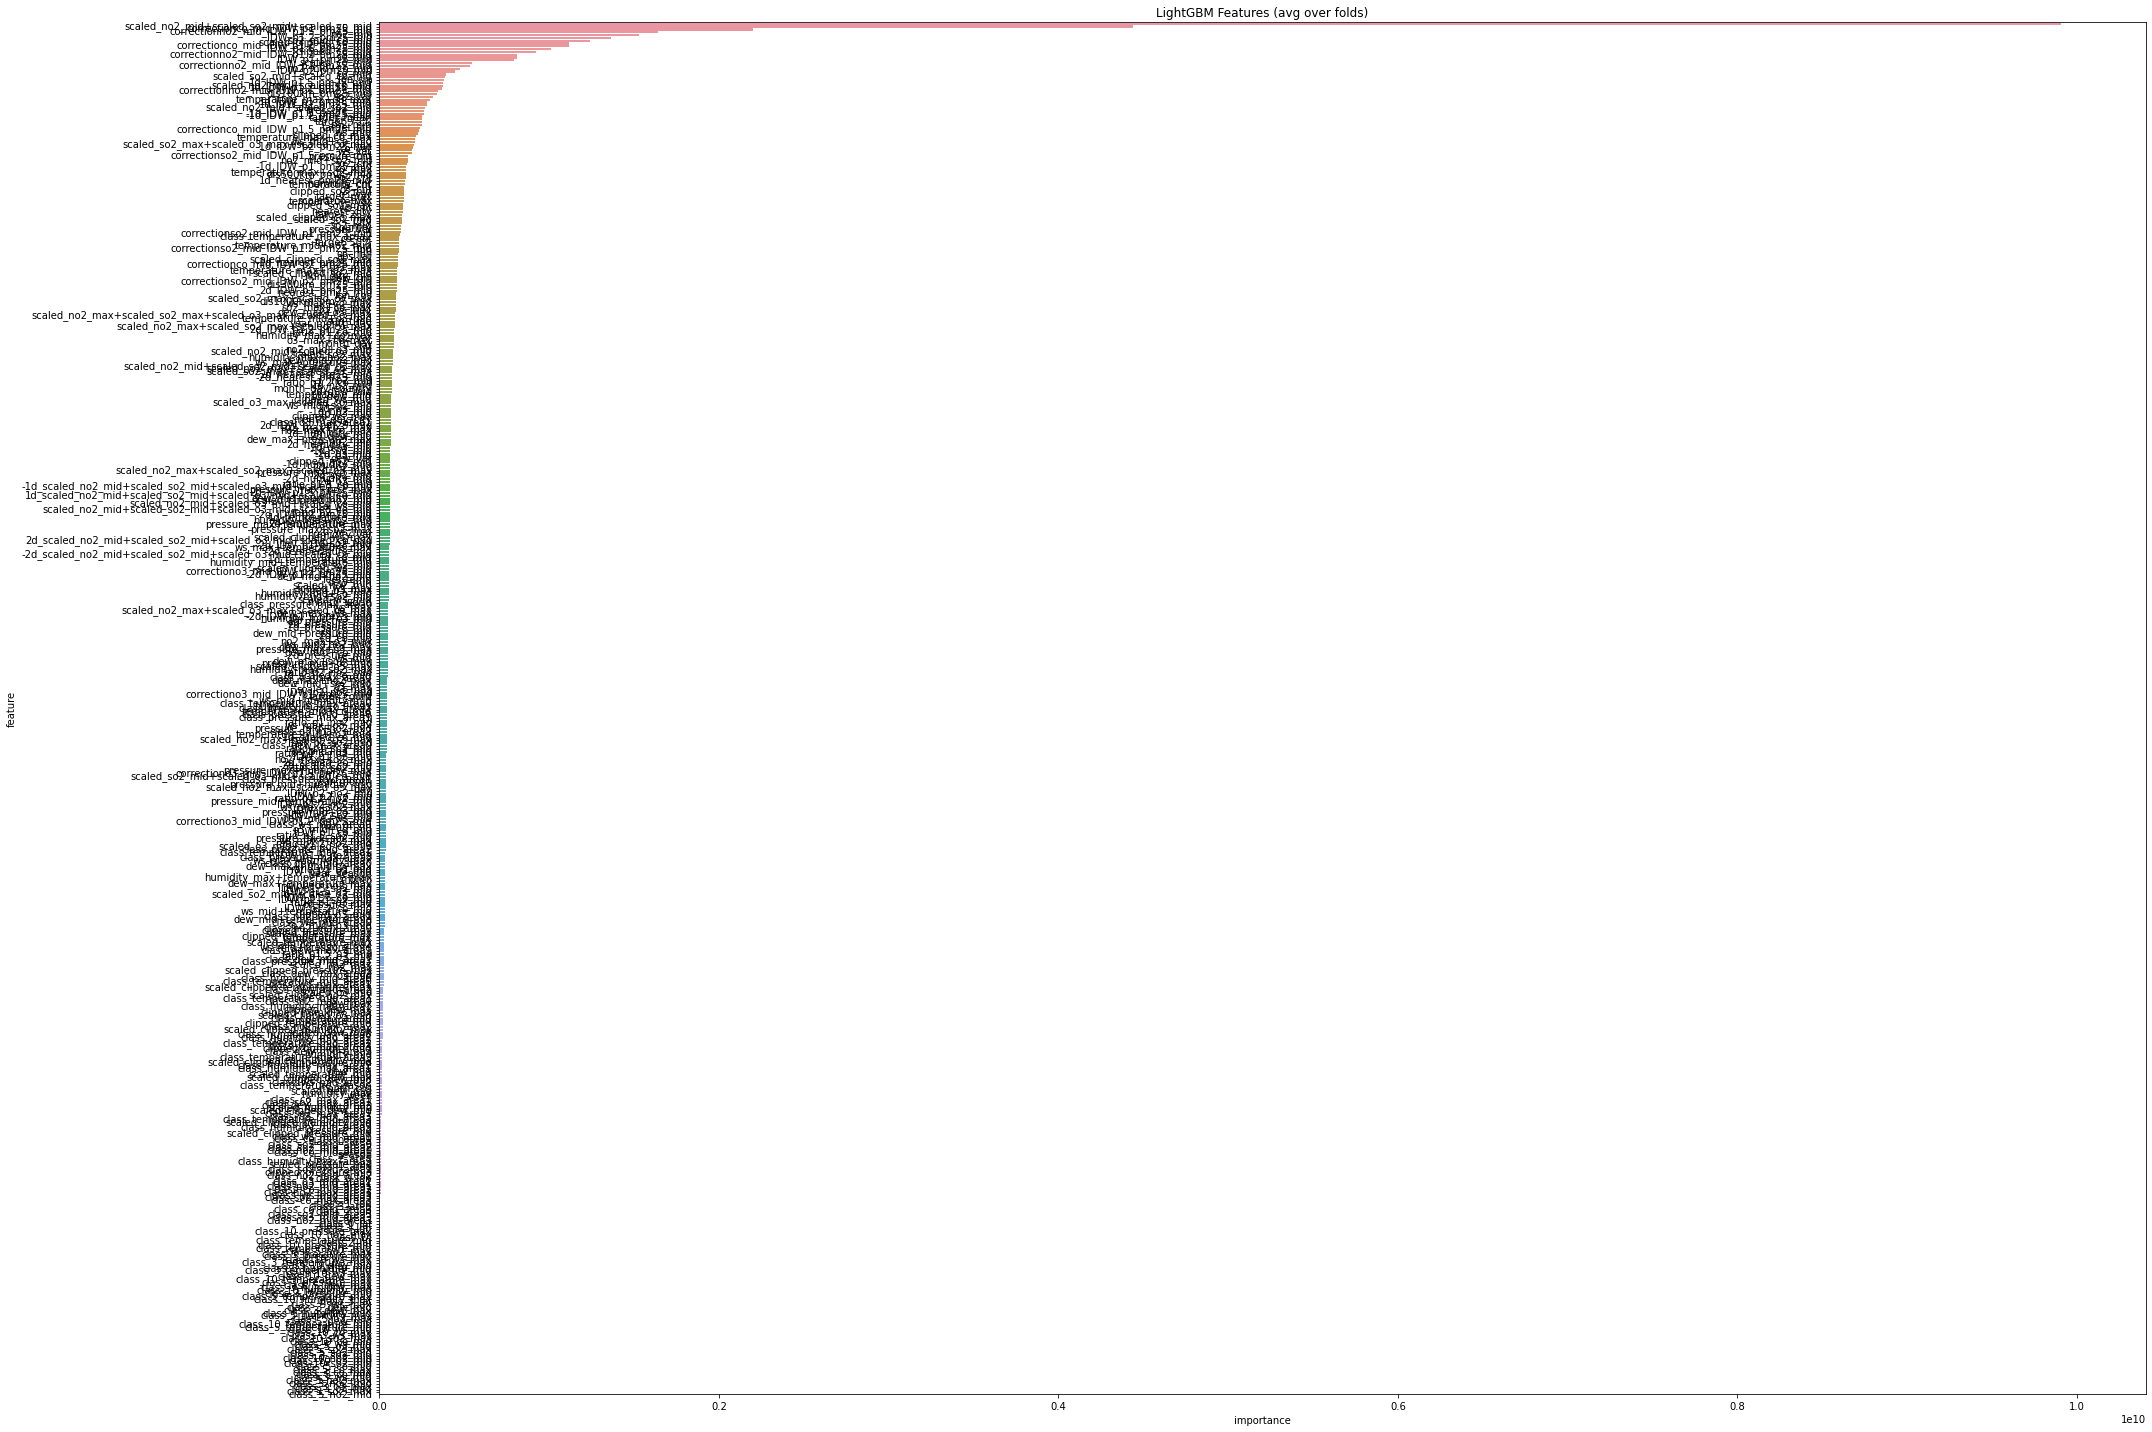

In [63]:
viz_feature_importances(feature_importance)

In [64]:
feature_importance.groupby("feature").agg({
    "importance": ["mean", "std"]
}).sort_values(("importance", "mean"), ascending=0).head(50)

importance    
                                                     mean std
feature                                                      
scaled_no2_mid+scaled_so2_mid+scaled_co_mid  9.909595e+09 NaN
correctionco_mid_IDW_p1_pm25_mid             4.442380e+09 NaN
correctionno2_mid_IDW_p1.5_pm25_mid          2.199761e+09 NaN
no2_min                                      1.644427e+09 NaN
IDW_p1.2_pm25_mid                            1.529563e+09 NaN
so2_mid+co_mid                               1.366530e+09 NaN
scaled_clipped_co_mid                        1.239075e+09 NaN
correctionco_mid_IDW_p1.2_pm25_mid           1.118289e+09 NaN
IDW_p1.5_pm25_mid                            1.116935e+09 NaN
clipped_co_mid                               1.010011e+09 NaN
correctionno2_mid_IDW_p1.2_pm25_mid          9.233486e+08 NaN
co_mid                                       8.117409e+08 NaN
IDW_p1_pm25_mid                              8.104405e+08 NaN
scaled_co_mid                                7.920395e+08 NaN
correctionno2_mid_IDW_p2_pm25_mid            5.473421e+08 NaN
no2_mid+co_mid                               5.348067e+08 NaN
IDW_p2_pm25_mid                              4.723957e+08 NaN
co_min                                       4.451170e+08 NaN
scaled_so2_mid+scaled_co_mid                 3.934462e+08 NaN
lon_sin                                      3.885399e+08 NaN
1d_IDW_p1.5_pm25_mid                         3.826425e+08 NaN
scaled_no2_mid+scaled_co_mid                 3.769012e+08 NaN
1d_IDW_p1.2_pm25_mid                         3.750475e+08 NaN
correctionno2_mid_IDW_p1_pm25_mid            3.694203e+08 NaN
dis100km_pm25_mid                            3.461494e+08 NaN
so2_var                                      3.422069e+08 NaN
temperature_max+o3_max                       3.179237e+08 NaN
1d_IDW_p1_pm25_mid                           2.977506e+08 NaN
1d_IDW_p2_pm25_mid                           2.823024e+08 NaN
scaled_no2_mid+scaled_so2_mid                2.812424e+08 NaN
pressure_min                                 2.668758e+08 NaN
-1d_IDW_p1.5_pm25_mid                        2.632036e+08 NaN
-1d_IDW_p1.2_pm25_mid                        2.627177e+08 NaN
target_mean                                  2.536673e+08 NaN
target_75%                                   2.531946e+08 NaN
so2_min                                      2.514001e+08 NaN
target_std                                   2.495100e+08 NaN
correctionco_mid_IDW_p1.5_pm25_mid           2.380191e+08 NaN
ws_min                                       2.359500e+08 NaN
clipped_co_max                               2.304996e+08 NaN
temperature_max+co_max                       2.175613e+08 NaN
ws_mid+co_mid                                2.111141e+08 NaN
scaled_so2_max+scaled_o3_max+scaled_co_max   2.104246e+08 NaN
-1d_IDW_p2_pm25_mid                          2.051186e+08 NaN
co_var                                       1.954382e+08 NaN
ws_var                                       1.905397e+08 NaN
correctionso2_mid_IDW_p1.5_pm25_mid          1.898715e+08 NaN
pressure_cnt                                 1.705516e+08 NaN
no2_mid+so2_mid                              1.696625e+08 NaN
so2_cnt                                      1.689957e+08 NaN

In [65]:
a = np.clip(train_oof["oof"], 0, 1000)
oof_score = np.sqrt(mean_squared_error(train_oof["pm25_mid"], a))
oof_score = format(oof_score, ".4f")
print(f"oof score: {oof_score}")

### 23.223 normal
### -1d, 1d 

oof score: 21.3342


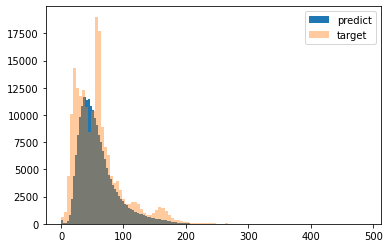

In [66]:
plt.hist(a, bins = 100, label = "predict")
plt.hist(train_oof["pm25_mid"], bins = 100, label = "target", alpha = 0.4)
plt.legend()
plt.show()

In [67]:
train_oof[["id","pm25_mid", "kfold", "oof"]].to_csv(os.path.join(OOF_DIR, "oof.csv"), index= False)

In [68]:
models = []
for i in range(NUM_FOLDS):
    with open(os.path.join(SAVE_DIR, f"model_{i}.pkl"), "rb") as p:
        model = pickle.load(p)
    models.append(model)

# predict

In [69]:
sum_predict = None
for model in models:
    predict = model.predict(
        test_df__[use_cols],
    )
    if sum_predict is None:
        sum_predict = predict
    else:
        sum_predict += predict

mean_predict = sum_predict / len(models)

In [70]:
print(len(mean_predict))
print(sample_df.shape)
print(test_df.shape)

53509
(53509, 2)
(53509, 255)


In [71]:
sample_df.loc[:,"predict"] = np.clip(mean_predict, 0, 450)

In [72]:
sample_df.head()

,id,predict
0,195942,24.117563
1,195943,38.413583
2,195944,29.647266
3,195945,73.142050
4,195946,128.027749


In [73]:
sample_df.to_csv(os.path.join(SUB_DIR, "submission.csv"), index= False, header = False)

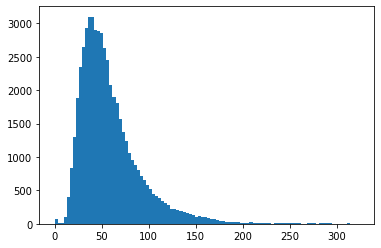

In [74]:
plt.hist(sample_df["predict"], bins = 100)
plt.show()

# submit

In [75]:
!pip install signate > /dev/null
!mkdir /root/.signate
!cp /content/drive/MyDrive/signate/signate.json /root/.signate/signate.json

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0+zzzcolab20220506162203 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
google-colab 1.0.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [76]:
submission_file = os.path.join(SUB_DIR, "submission.csv")

In [77]:
comment = f"cv:{oof_score}_" + NOTEBOOK_NAME
comment

'cv:21.3342_FP083-082'

# Submit

In [78]:
!signate submit --competition-id=624 {submission_file} --note {comment}

You have successfully submitted your predictions.We will send you the submission result to your email address.


https://signate.jp/competitions/624/submissions

In [79]:
train_df[["City", "month", "pm25_mid"]].groupby(["City"]).describe()

month                                                pm25_mid  \
              count      mean       std  min  25%  50%   75%   max    count   
City                                                                          
Adapazarı     962.0  6.536383  3.356269  1.0  4.0  6.0   9.0  12.0    962.0   
Akita         978.0  6.527607  3.436774  1.0  4.0  6.0  10.0  12.0    978.0   
Albuquerque   917.0  6.679389  3.347707  1.0  4.0  7.0  10.0  12.0    917.0   
Andong       1011.0  6.608309  3.431492  1.0  4.0  7.0  10.0  12.0   1011.0   
Antakya       734.0  6.779292  3.200069  1.0  4.0  7.0  10.0  12.0    734.0   
...             ...       ...       ...  ...  ...  ...   ...   ...      ...   
Zhuzhou      1059.0  6.610954  3.425374  1.0  4.0  7.0  10.0  12.0   1059.0   
Ürümqi       1033.0  6.642788  3.399611  1.0  4.0  7.0  10.0  12.0   1033.0   
İzmit        1013.0  6.553801  3.346923  1.0  4.0  7.0   9.0  12.0   1013.0   
Łódź          753.0  6.701195  3.238681  1.0  4.0  7.0   9.0  12.0    753.0   
Ōita         1057.0  6.621570  3.406298  1.0  4.0  7.0  10.0  12.0   1057.0   

                                                                         \
                  mean        std     min       25%      50%        75%   
City                                                                      
Adapazarı    63.232831  35.395245   6.460  39.56125  55.6930   73.47475   
Akita        45.871133  25.458542   6.364  28.59525  40.5160   57.69725   
Albuquerque  42.865439  28.188976   7.736  22.31000  34.6630   57.03700   
Andong       59.396874  31.321281   6.600  37.84050  56.9850   69.45200   
Antakya      58.372569  41.630375   2.125  27.77575  53.3615   68.76650   
...                ...        ...     ...       ...      ...        ...   
Zhuzhou      88.612365  43.927142  13.978  57.70200  75.5570  117.65500   
Ürümqi       81.598576  57.824517   9.867  47.92700  61.1770   92.37700   
İzmit        57.312069  29.037306   8.437  36.52600  54.2140   68.27100   
Łódź         61.209457  30.803510  11.894  40.49800  56.6420   73.41000   
Ōita         43.637044  20.845038   6.685  26.33400  40.2000   57.08000   

                      
                 max  
City                  
Adapazarı    181.469  
Akita        218.085  
Albuquerque  173.738  
Andong       191.630  
Antakya      286.452  
...              ...  
Zhuzhou      236.485  
Ürümqi       406.464  
İzmit        176.600  
Łódź         216.704  
Ōita         135.558  

[239 rows x 16 columns]

In [80]:
test_df__[["IDW_p1_pm25_mid", "IDW_p2_pm25_mid"]]

,IDW_p1_pm25_mid,IDW_p2_pm25_mid
0,90.797173,76.148287
1,109.860292,124.893974
2,76.935167,65.691167
3,102.925348,121.052838
4,80.203378,68.010018
...,...,...
53504,72.703882,95.819913
53505,60.934877,57.623437
53506,73.706546,98.219577
53507,63.027719,77.876075


In [81]:
train_df[["co_cnt", "co_var", "co_min", "co_max", "co_mid"]]

,co_cnt,co_var,co_min,co_max,co_mid
0,38,0.850,0.749,2.633,2.590
1,47,1.208,2.594,4.828,3.181
2,17,0.248,1.190,2.200,1.197
3,63,24.186,4.586,14.802,11.044
4,47,10.011,4.689,11.100,8.681
...,...,...,...,...,...
195936,12,0.090,0.694,1.301,0.995
195937,14,1.743,0.528,3.226,1.256
195938,171,5.293,1.975,6.639,6.627
195939,31,4.317,2.613,8.767,2.704


In [82]:
gen = np.random.default_rng()
rnd = gen.normal(size=38)
print(len(rnd), rnd.mean(), rnd.std())

38 0.2254211235638918 1.0334763043757929


(array([ 1.,  0.,  0.,  2.,  5.,  5., 10.,  9., 13., 17., 19., 22., 14.,
        17., 22., 20., 25., 25., 16., 27., 19., 20., 23., 21., 27., 27.,
        32., 38., 47., 41., 31., 34., 13., 22., 18.,  3., 13., 20., 11.,
        15., 11.,  8.,  7.,  7.,  6.,  3.,  3.,  9.,  6.,  6.,  9.,  4.,
         2.,  6.,  2.,  4.,  2.,  2.,  4.,  1.,  5.,  2.,  6.,  4.,  9.,
         7.,  2.,  4.,  2.,  3.,  1.,  1.,  2.,  4.,  2.,  2.,  2.,  2.,
         4.,  0.,  3.,  2.,  2.,  3.,  4.,  3.,  2.,  7.,  5.,  5.,  1.,
         3.,  3.,  0.,  2.,  1.,  2.,  2.,  0.,  2.]),
 array([  6.46   ,   8.21009,   9.96018,  11.71027,  13.46036,  15.21045,
         16.96054,  18.71063,  20.46072,  22.21081,  23.9609 ,  25.71099,
         27.46108,  29.21117,  30.96126,  32.71135,  34.46144,  36.21153,
         37.96162,  39.71171,  41.4618 ,  43.21189,  44.96198,  46.71207,
         48.46216,  50.21225,  51.96234,  53.71243,  55.46252,  57.21261,
         58.9627 ,  60.71279,  62.46288,  64.21297,  65.96306,  

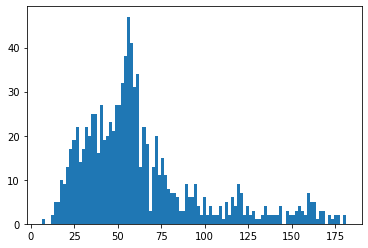

In [83]:
plt.hist(train_df[train_df["City"] == "Adapazarı"]["pm25_mid"], bins = 100)